# ELEC0054 20/21 Project - The Smart Building & City Lens
This notebook serves as the code implementation (forcast part) of the project assigned in the module ELEC0054 in the Department of Electronic and Electrical Engineering in UCL.

In [1]:
# -*- encoding:utf-8 -*-

import datetime
import warnings  # ignore the warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF

warnings.filterwarnings('ignore')


# plt.rcParams['font.sans-serif'] = ['SimHei']  # plot labels in Chinese
plt.rcParams['axes.unicode_minus'] = False

## Data Acquisition

In [2]:
# Connect to local MongoDB database
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["ucl-smartcity"]
mydb_list = ['AirqualityMonitoringSite', 'cities', 'COReadings', 'COSensor', 'NO2Readings', 'NO2Sensor', 'O3Readings', 'O3Sensor',
             'PM10Readings', 'PM10Sensor', 'PM25Readings', 'PM25Sensor', 'SO2Readings', 'SO2Sensor',
             'HumidityReadings',
             'PressureReadings',
             'TempReadings']

# Store data into local CSV files
for x in mydb_list:
    data = pd.DataFrame(list(mydb[x].find()))
    data.to_csv('data/%s.csv' % x)

## Data Analysis and Modeling (demo)
Show the whole process in details, here take CO as an example since there are only 2 valid monitoring stations for CO.

### Loading air quality data from CSV files

In [3]:
FilePath_CoSensor = 'data/COSensor.csv'
FilePath_Site = 'data/AirqualityMonitoringSite.csv'
FilePath_Co = 'data/COReadings.csv'
FilePath_monitoring = 'data/monitoring.csv'

data_Co = pd.read_csv(FilePath_Co).iloc[:, 2:]
data_CoSensor = pd.read_csv(FilePath_CoSensor)
data_Site = pd.read_csv(FilePath_Site)
data_monitoring = pd.read_csv(FilePath_monitoring).iloc[:, 1:]

### Preprocessing the air quality data

In [4]:
data_Co['siteid'] = ''
data_Co.loc[data_Co['sensorid'] == 'KC1-CO', 'siteid'] = 'KC1'
# data_Co.loc[data_Co['sensorid'] == 'MY1-CO', 'siteid'] = 'MY1'

data_Co = pd.merge(data_Co, data_Site)

# Remove the unwanted columns
data_Co_columns = ['sensorid', 'Unnamed: 0', '_id', 'cityid', 'postcode']
data_Co = data_Co.drop(data_Co_columns, axis=1).groupby('siteid', sort=False)\
    .apply(lambda x: x.sort_values('recordtime', ascending=False))\
    .reset_index(drop=True)

In [5]:
print(data_Co)

                recordtime  value siteid   latitude  longitude
0      2021-09-12 09:00:00    NaN    KC1  51.521047  -0.213492
1      2021-09-12 08:00:00    0.3    KC1  51.521047  -0.213492
2      2021-09-12 07:00:00    0.3    KC1  51.521047  -0.213492
3      2021-09-12 06:00:00    0.3    KC1  51.521047  -0.213492
4      2021-09-12 05:00:00    0.4    KC1  51.521047  -0.213492
...                    ...    ...    ...        ...        ...
58808  2015-01-01 04:00:00    0.3    KC1  51.521047  -0.213492
58809  2015-01-01 03:00:00    0.3    KC1  51.521047  -0.213492
58810  2015-01-01 02:00:00    0.3    KC1  51.521047  -0.213492
58811  2015-01-01 01:00:00    0.3    KC1  51.521047  -0.213492
58812  2015-01-01 00:00:00    0.3    KC1  51.521047  -0.213492

[58813 rows x 5 columns]


In [6]:
# Set 'recordtime' as index to deal with the time-series data
data_Co_columns = ['recordtime', 'CO', 'siteid', 'latitude', 'longitude']
data_Co.columns = data_Co_columns
data_Co['recordtime'] = pd.to_datetime(
    data_Co['recordtime'], format='%Y-%m-%d %H:%M:%S')
data_Co = data_Co.set_index(['recordtime'])

# Drop the duplicated and null data
# data_Co = data_Co.drop_duplicates()
data_count = data_Co.shape[0]
data_Co = data_Co.loc[data_Co['CO'] >= 0]
error = data_count - data_Co.shape[0]
print('There are %i null data.' % (error))

# Extract data according to the monitoring site
data_Co_A = data_Co.loc[data_Co['siteid'] == 'KC1']
# data_Co_B = data_Co.loc[data_Co['siteid'] == 'MY1']

# Use KC1 data as demo
df = data_Co_A['CO'].dropna()
u = df.mean()  # mean
std = df.std()  # standard deviation

# Detect and drop the outliers
data_c = df[np.abs(df - u) <= 3*std]
error = df[np.abs(df - u) > 3*std]
print('There are %i outliers.' % (len(error)))

# Resample data into day granularity and interpolate the missing value
data_c = data_c.resample('D').mean().interpolate('linear')
data_c[np.isnan(data_c)] = 0
data_c[np.isinf(data_c)] = 0

# Detect and drop the outliers for the second time in case outliers are generated during resampling and interpolation
df = data_c.dropna()
u = df.mean()  # mean
std = df.std()  # standard deviation

data_c = df[np.abs(df - u) <= 3*std]
error = df[np.abs(df - u) > 3*std]
print('There are %i outliers.' % (len(error)))

# Resample data into day granularity and interpolate the missing value
data_c = data_c.resample('D').mean().interpolate('linear')
data_c[np.isnan(data_c)] = 0
data_c[np.isinf(data_c)] = 0

There are 2099 null data.
There are 825 outliers.
There are 28 outliers.


In [7]:
print(data_c)

recordtime
2015-01-01    0.291667
2015-01-02    0.266667
2015-01-03    0.316667
2015-01-04    0.417391
2015-01-05    0.362500
                ...   
2021-09-08    0.395652
2021-09-09    0.241667
2021-09-10    0.266667
2021-09-11    0.258333
2021-09-12    0.255556
Freq: D, Name: CO, Length: 2447, dtype: float64


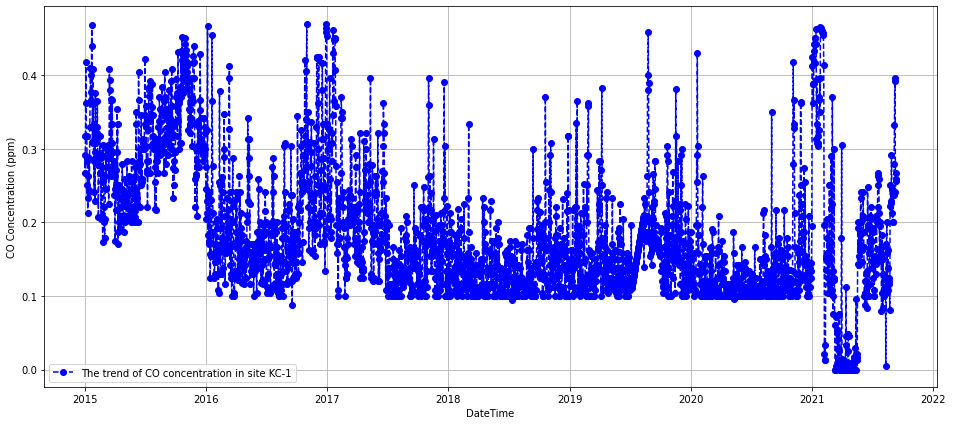

In [8]:
# Plot the trend of CO concentration in site KC-1
plt.figure(figsize=(16, 7))
plt.plot(data_c,
         label='The trend of CO concentration in site KC-1',
         linestyle='--',
         marker='o',
         c='b')

plt.xlabel('DateTime')
plt.ylabel('CO Concentration (ppm)')

plt.grid()
plt.legend()
plt.show()

In [9]:
# Keep the last year data and drop the rest
today = datetime.date.today()
last_year = today.year-1
last_time = datetime.datetime(month=today.month, year=last_year, day=today.day)
# data_c['recordtime'] = pd.to_datetime(data_c['recordtime'])
data_c = data_c.loc[data_c.index >= last_time].dropna()

In [10]:
data_c.describe()

count    349.000000
mean       0.161280
std        0.117769
min        0.000000
25%        0.100000
50%        0.137500
75%        0.208333
max        0.465000
Name: CO, dtype: float64

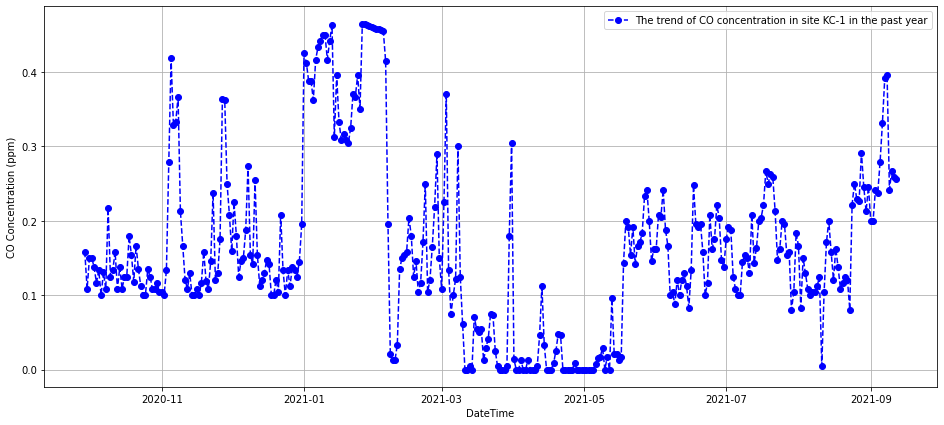

In [11]:
# Plot the trend of CO concentration in site KC-1 in the past year
plt.figure(figsize=(16, 7))
plt.plot(data_c,
         label='The trend of CO concentration in site KC-1 in the past year',
         linestyle='--',
         marker='o',
         c='b')

plt.xlabel('DateTime')
plt.ylabel('CO Concentration (ppm)')

plt.grid()
plt.legend()
plt.show()

The method of Z-score is applied to detect the possible outliers in the data.  
The Z-score is the signed number of standard deviations, calculated by following equation:

$z=\frac{x-\overline{x}}{S}$

where $\overline{x}$ is the mean value, $S$ is the standard deviation.

Z-score: 
 recordtime
2020-09-29    0.025059
2020-09-30    0.450228
2020-10-01    0.095920
2020-10-02    0.095920
2020-10-03    0.202213
                ...   
2021-09-08    1.992956
2021-09-09    0.683557
2021-09-10    0.896142
2021-09-11    0.825280
2021-09-12    0.801660
Freq: D, Name: CO, Length: 349, dtype: float64


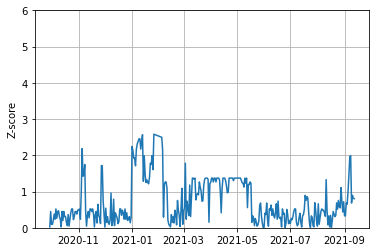

In [12]:
# Detect whether there are outliers in the preprocessed dataset
from scipy import stats

outlier_dataset = data_c
outlier_year = data_c.index

# Calculate the absolute value of Z-score
z = np.abs(stats.zscore(outlier_dataset))

print('Z-score: \r\n', z)

plt.plot(outlier_year, z)
plt.grid()
plt.ylim([0, 6])
plt.ylabel('Z-score')
plt.show()

In general, we **put a threshold on Z-scores**. Typically, the threshold is 3.  
If $|z\_score|>3$, then it is an outlier.  

From the figure we can observe that all the z-scores are less than 3, so there is no outlier in this dataset.

### Preprocessing the weather data

In [13]:
FilePath_Humid = 'data/HumidityReadings.csv'
FilePath_Press = 'data/PressureReadings.csv'
FilePath_Temp = 'data/TempReadings.csv'

data_Weather = pd.read_csv(FilePath_Humid).iloc[:, 2:4]
data_Press = pd.read_csv(FilePath_Press).iloc[:, 3]
data_Temp = pd.read_csv(FilePath_Temp).iloc[:, 3]

In [14]:
data_Weather.columns = ['recordtime', 'humidity']
data_Weather['pressure'] = data_Press
data_Weather['temperature'] = data_Temp

data_Weather['recordtime'] = pd.to_datetime(
    data_Weather['recordtime'], format='%Y-%m-%d %H:%M:%S')
data_Weather = data_Weather.set_index(['recordtime'])

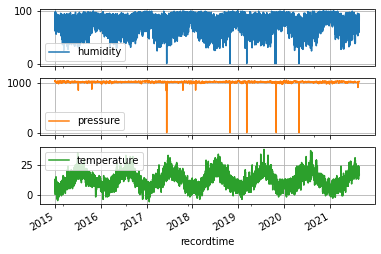

In [15]:
data_Weather.plot(grid=True, subplots=True)
plt.legend(loc='best')

In [16]:
# Keep the last year data and drop the rest
data_Weather = data_Weather.loc[data_Weather.index >= last_time].dropna()

# Resample data into day granularity
data_Weather = data_Weather.resample('D').mean().interpolate('linear')

In [17]:
data_Weather

,humidity,pressure,temperature
recordtime,,,
2020-09-29,85.25,1015.00,16.25
2020-09-30,89.50,1007.00,15.25
2020-10-01,81.00,997.00,13.50
2020-10-02,93.00,988.00,12.75
2020-10-03,92.75,985.75,14.25
...,...,...,...
2021-08-19,75.75,1014.00,18.75
2021-08-20,81.25,1015.75,19.00
2021-08-21,84.25,1015.00,18.75


### Exploratory Data Analysis

In [18]:
data_Weather['CO'] = data_c
data_Weather.describe()

,humidity,pressure,temperature,CO
count,329.000000,329.000000,329.000000,329.000000
mean,79.935790,1013.857143,11.809650,0.155212
std,10.930195,11.497390,5.795889,0.117885
min,52.000000,974.500000,-1.000000,0.000000
25%,72.250000,1006.750000,8.000000,0.100000
50%,82.000000,1015.500000,11.250000,0.133333
75%,88.250000,1022.000000,15.625000,0.195833
max,99.750000,1040.250000,27.000000,0.465000


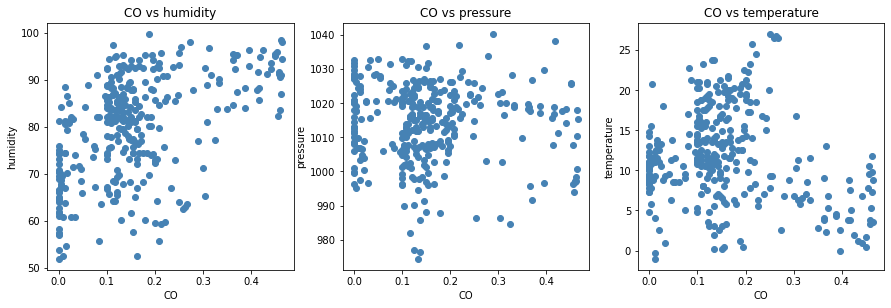

In [19]:
# Visualize the relevance between the CO and weather
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.scatter(x = data_Weather['CO'],
            y = data_Weather['humidity'],
            color = 'steelblue'
           )
plt.xlabel('CO')
plt.ylabel('humidity')
plt.title('CO vs humidity')

plt.subplot(232)
plt.scatter(x = data_Weather['CO'],
            y = data_Weather['pressure'],
            color = 'steelblue'
           )
plt.xlabel('CO')
plt.ylabel('pressure')
plt.title('CO vs pressure')

plt.subplot(233)
plt.scatter(x = data_Weather['CO'],
            y = data_Weather['temperature'],
            color = 'steelblue'
           )
plt.xlabel('CO')
plt.ylabel('temperature')
plt.title('CO vs temperature')

plt.show()

CO R^2 score: -0.091408


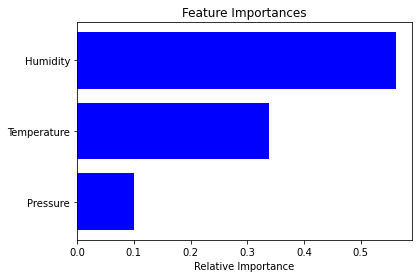

In [20]:
# Measure the relevance between the CO and weather and visualize the feature importance of weather data in predicting CO value
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

for col in list(['CO']):
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data_Weather.drop(col, axis=1)

    # Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data,
                                                        data_Weather[col],
                                                        test_size=0.3,
                                                        random_state=2021)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("{} R^2 score: {:2f}".format(col, score))

    # Plot the importances of features
    columns = ['Humidity', 'Pressure', 'Temperature', 'CO']
    importances = regressor.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

The coefficient of determination, R^2, is scored between 0 and 1, with 1 being a perfect fit. A negative R^2 implies the model fails to fit the data.

Based on the R^2 score, it looks like R^2 of CO is a negative score which makes it not being much useful for our predictions since the model couldn't fit trying to predict CO using the others.

Thus, we merely keep air quality data for further modelling.

### ARIMA model
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

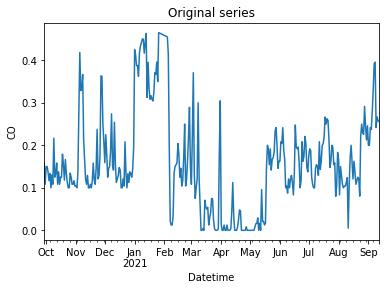

In [21]:
# Draw the original time-series plot
# Check whether the data are stationary
data_c.plot()

# plt.xticks(rotation=45)
plt.xlabel('Datetime')
plt.ylabel('CO')
plt.title('Original series')
plt.show()

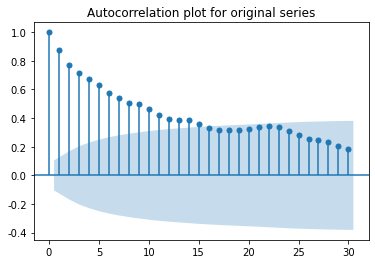

In [22]:
# Draw autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_c, use_vlines=True, lags=30)
plt.title('Autocorrelation plot for original series')
plt.show()

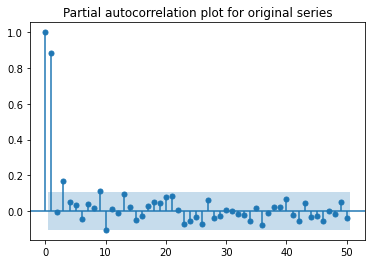

In [23]:
# Draw partial autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data_c, use_vlines=True, lags=50)
plt.title('Partial autocorrelation plot for original series')
plt.show()

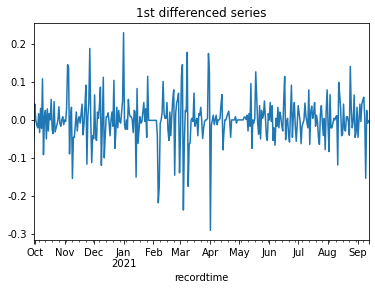

In [24]:
# 1st Differencing
D_ts = data_c.diff().dropna()
D_ts.columns = ['1st Differencing']

# Draw the time-series plot after 1st differencing
D_ts.plot()
plt.title('1st differenced series')
plt.show()

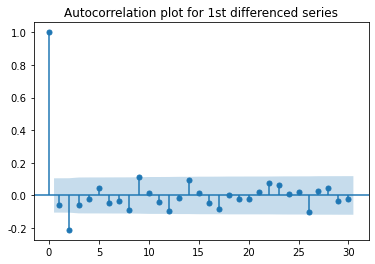

In [25]:
# Draw autocorrelation plot after 1st differencing
from statsmodels.graphics.tsaplots import plot_acf 

plot_acf(D_ts, use_vlines=True, lags=30)
plt.title('Autocorrelation plot for 1st differenced series')
plt.show()

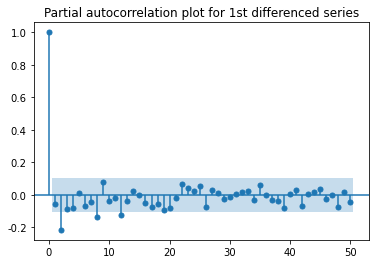

In [26]:
# Draw partial autocorrelation plot after 1st differencing
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(D_ts, use_vlines=True, lags=50)
plt.title('Partial autocorrelation plot for 1st differenced series')
plt.show()

In [27]:
# ADF Test
print('ADF test for the original series: ', ADF(data_c))
print('ADF test for the 1st differenced series: ', ADF(D_ts))

ADF test for the original series:  (-3.6796232449979227, 0.004409073896182312, 2, 346, {'1%': -3.4493918438232525, '5%': -2.8699298018856574, '10%': -2.5712397066390458}, -965.5841529911509)
ADF test for the 1st differenced series:  (-7.320342841245893, 1.1987638773867967e-10, 8, 339, {'1%': -3.4497880749874628, '5%': -2.870103829170425, '10%': -2.571332495975496}, -952.6202091982836)


In [28]:
# Ljung-Box Test
from statsmodels.stats.diagnostic import acorr_ljungbox

print('Ljung-Box test for the original series: ', acorr_ljungbox(data_c, lags=1))

Ljung-Box test for the original series:  (array([272.23749515]), array([3.69202173e-61]))


In [ ]:
# !!!Warning!!! This cell operation is very time consuming, cost nearly 30 mins on GPU server.
# Find the order of p and q using BIC
data_c = data_c.astype(float)
pmax = int(len(data_c)/10)
qmax = int(len(data_c)/10)
bic_matrix = []

for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(data_c, (p, 0, q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

# Find the minimum from BIC matrix to determine p and q
bic_matrix = pd.DataFrame(bic_matrix)
p, q = bic_matrix.stack().idxmin()

print(u'The order of p and q are：%s、%s.' % (p, q))

                              ARMA Model Results                              
Dep. Variable:                     CO   No. Observations:                  280
Model:                     ARMA(2, 1)   Log Likelihood                 403.304
Method:                       css-mle   S.D. of innovations              0.057
Date:                Wed, 29 Sep 2021   AIC                           -796.609
Time:                        18:21:15   BIC                           -778.435
Sample:                    09-29-2020   HQIC                          -789.319
                         - 07-05-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1552      0.028      5.465      0.000       0.100       0.211
ar.L1.CO       0.0014      0.063      0.023      0.982      -0.122       0.125
ar.L2.CO       0.7685      0.061     12.516      0.0

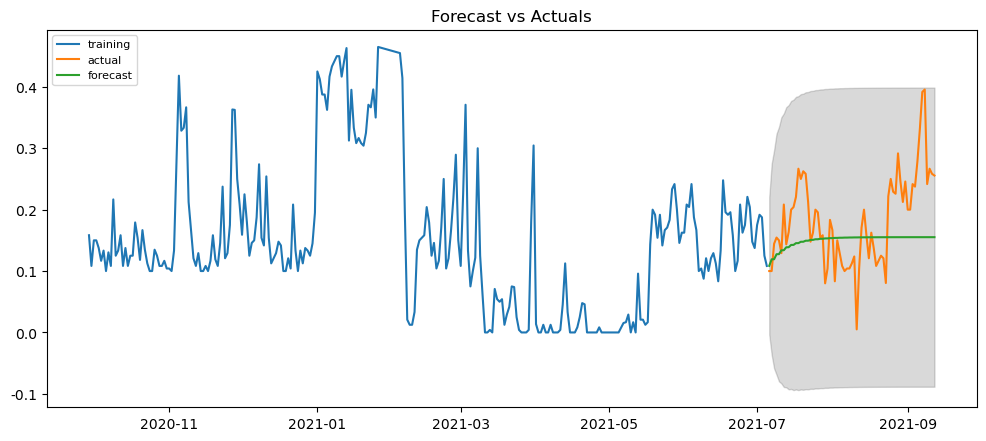

In [30]:
# Create training and testing set
train = data_c[:280]
test = data_c[280:]

# Build model
model = ARIMA(train, order=(2, 0, 1), freq='D')  # p=2, d=0, q=1
result = model.fit(disp = -1)
print(result.summary())
print(result.conf_int())

# Forecast
fc, se, conf = result.forecast(69, alpha=0.05)  # 95% conf

# Make a pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

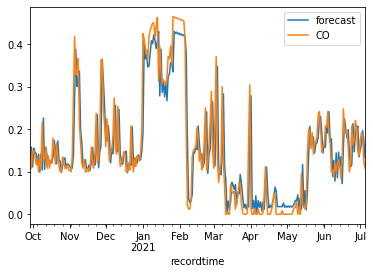

In [31]:
# Actual vs Fitted
result.plot_predict(dynamic=False)
plt.show()

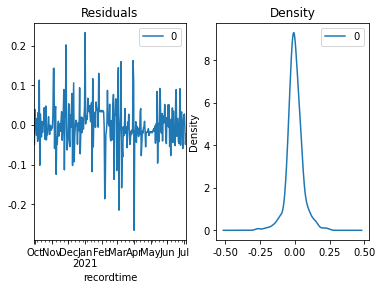

In [32]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [33]:
from statsmodels.tsa.stattools import acf

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.7436950502283819,
 'me': -0.03218900798432405,
 'mae': 0.061395296621967736,
 'mpe': 0.36961484388391785,
 'rmse': 0.07883367483372537,
 'acf1': 0.7707562381906222,
 'corr': 0.18514732961183877,
 'minmax': 0.28249434850872535}

In [34]:
# Forcast for 3 steps (coming days)
result_c = result.forecast(3)

CO_values = np.empty(1, dtype=object)
CO_values[0] = result_c[0].tolist()
CO_values = 'Tomorrow: '+str(abs(CO_values[0][0])) + '\nThe day after tomorrow:'+str(
    abs(CO_values[0][1])) + '\nTwo days later:'+str(abs(CO_values[0][2]))

print(CO_values)

Tomorrow: 0.10848861205244134
The day after tomorrow:0.1191145957199495
Two days later:0.11924922176257083


In [35]:
# Save the forcasts into local file
data_monitoring.loc[data_monitoring['sitecode'] == 'KC1', 'CO'] = CO_values

data_monitoring.to_csv('data/monitoring.csv')
print('CO for next three days: \n', result_c[0])

CO for next three days: 
 [0.10848861 0.1191146  0.11924922]


## Data Analysis and Modeling (general)

In [36]:
def prediction(pollutant):
    FilePath_CoSensor = f'data/{pollutant}Sensor.csv'
    FilePath_Site = 'data/AirqualityMonitoringSite.csv'
    FilePath_Co = f'data/{pollutant}Readings.csv'
    FilePath_monitoring = 'data/monitoring.csv'

    # Loading data
    data_Co = pd.read_csv(FilePath_Co).iloc[:, 2:]
    data_CoSensor = pd.read_csv(FilePath_CoSensor)
    data_Site = pd.read_csv(FilePath_Site)
    data_monitoring = pd.read_csv(FilePath_monitoring).iloc[:, 1:]

    # Keep the last year data and drop the rest
    today = datetime.date.today()
    last_year = today.year-1
    last_time = datetime.datetime(
        month=today.month, year=last_year, day=today.day)
    data_Co['recordtime'] = pd.to_datetime(data_Co['recordtime'])
    data_Co = data_Co.loc[data_Co['recordtime'] >= last_time].dropna()

    data_Co['siteid'] = ''
    sensorid = list(set(list(data_Co['sensorid'])))
    for x in sensorid:
        data_Co.loc[data_Co['sensorid'] == x, 'siteid'] = x[:3]

    data_Co = pd.merge(data_Co, data_Site)

    # Remove the unwanted columns
    data_Co_columns = ['sensorid', 'Unnamed: 0', '_id', 'cityid', 'postcode']
    data_Co = data_Co.drop(data_Co_columns, axis=1).groupby('siteid', sort=False)\
        .apply(lambda x: x.sort_values('recordtime', ascending=False))\
        .reset_index(drop=True)

    # Set 'recordtime' as index to deal with the time-series data
    data_Co_columns = ['recordtime', pollutant,
                       'siteid', 'latitude', 'longitude']
    data_Co.columns = data_Co_columns
    data_Co = data_Co.set_index(['recordtime'])
    data_Co = data_Co.loc[data_Co[pollutant] > 0]

    siteid = list(set(list(data_Co['siteid'])))

    for y in siteid:
        # Extract data according to the monitoring site
        # Drop the duplicated data
        data_Co_A = data_Co.loc[data_Co['siteid'] ==
                                y].drop_duplicates()

        # Detect and drop the outliers
        df = data_Co_A[pollutant].dropna()
        u = df.mean()
        std = df.std()
        data_c = df[np.abs(df - u) <= 3*std]

        # Resample data into day granularity and interpolate the missing value
        data_c = data_c.resample('D').mean().interpolate('linear')
        data_c[np.isnan(data_c)] = 0
        data_c[np.isinf(data_c)] = 0

        # 1st Differencing
        D_ts = data_c.diff().dropna()

        # Modeling
        model = ARIMA(D_ts, order=(4, 1, 0), freq='D')  # p,d,q
        result = model.fit(disp = -1)

        # Forcast for 3 steps (coming days)
        result_c = result.forecast(3)
        CO_values = np.empty(1, dtype=object)
        CO_values[0] = result_c[0].tolist()
        CO_values = 'Tomorrow: '+str(abs(CO_values[0][0])) + '\nThe day after tomorrow:'+str(
            abs(CO_values[0][1])) + '\nTwo days later:'+str(abs(CO_values[0][2]))

        print(result.summary())
        print(result.conf_int())
        print('Forcasts for next three days: \n', result_c)

        # Save the forcasts into local file
        data_monitoring.loc[data_monitoring['sitecode']
                            == y, pollutant] = CO_values

        data_monitoring.to_csv(FilePath_monitoring)

    return FilePath_monitoring

In [37]:
prediction('CO')
prediction('NO2')
prediction('O3')
prediction('SO2')
prediction('PM10')
prediction('PM25')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42803D+00    |proj g|=  3.45747D-01

At iterate    5    f= -2.42805D+00    |proj g|=  5.57817D-02

At iterate   10    f= -2.42805D+00    |proj g|=  5.05462D-04

At iterate   15    f= -2.42805D+00    |proj g|=  5.07181D-03

At iterate   20    f= -2.42805D+00    |proj g|=  3.01092D-05

At iterate   25    f= -2.42805D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     39      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07636D+00    |proj g|=  4.04667D-03

At iterate    5    f= -3.07636D+00    |proj g|=  2.84217D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     18      1     0     0   0.000D+00  -3.076D+00
  F =  -3.0763613532409240     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                   D.CO   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87678D+00    |proj g|=  1.10014D-03

At iterate    5    f=  3.87677D+00    |proj g|=  3.64597D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.332D-07   3.877D+00
  F =   3.8767687886779698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.


KeyboardInterrupt: 